## Imports, Google Drive Authentication and data loading

In [ ]:
# GOOGLE COLAB SPECIFIC 
# For importing utility notebooks and data from Google Drive and Google Colab
googlesheet_filename = 'clickbait_headlines'

#!pip install --upgrade -q gspread
#!pip install kora
from kora import drive
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())
worksheet = gc.open(googlesheet_filename).sheet1

## Load and process text documents to dataframe

In [ ]:
# Adapted from https://github.com/robsalgado/personal_data_science_projects/blob/master/topic_modeling_nmf/nlp_topic_utils.ipynb

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
import nltk

# Contraction map
c_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "here's": "here is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}

# Compiling the contraction dict
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

# List of stop words
add_stop = ['said', 'say', '...']
stop_words = ENGLISH_STOP_WORDS.union(add_stop)

# List of punctuation
punc = list(set(string.punctuation))


# Splits words on white spaces (leaves contractions intact) and splits out
# trailing punctuation
def casual_tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens


def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)


def process_text(text):
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    text = [expandContractions(each, c_re=c_re) for each in text]    
    text = [w for w in text if w not in punc]
    text = [w for w in text if w not in stop_words]
    text = [each for each in text if len(each) > 1]
    text = [each for each in text if ' ' not in each]
    return text


def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  


def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)


def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens


# Funtion to remove duplicate words
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist


def word_count(text):
    return len(str(text).split(' '))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

"""
GOOGLE PLATFORM SPECIFIC dataframe load from Google Sheets
"""
rows = worksheet.get_all_values()
df = pd.DataFrame.from_records(rows)
df.columns = df.iloc[0]
df = df[1:]

"""
LOCAL FILE dataframe load from CSV

file_path = '<YOUR FILE PATH>'
file_name = 'documents.csv'

df = pd.read_csv(file_path + file_name)
"""

df['processed_text'] = df['body'].apply(process_text)
df['word_count'] = df['body'].apply(word_count)
df.head(n=10)

In [9]:
import itertools

test = unique_words(df['processed_text'])
unique_words_list =set(list(itertools.chain.from_iterable(test)))
len(unique_words_list)

11973

## Corpus summary statistics

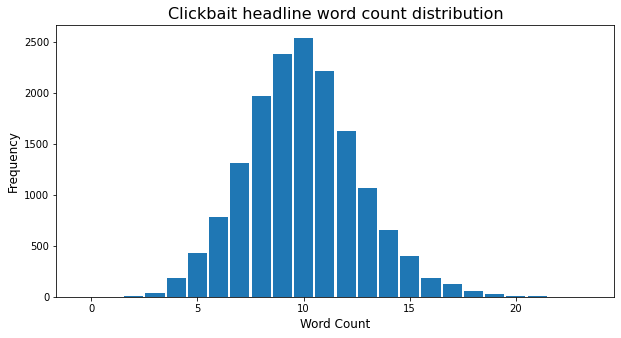

In [10]:
# Plot a hist of the word counts
fig = plt.figure(figsize=(10,5))

plt.hist(
    df['word_count'],
    bins=np.arange(25)-0.5,
    rwidth=0.9
)

plt.title('Clickbait headline word count distribution', fontsize=16)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Word Count', fontsize=12)

plt.show()

In [11]:
# Get the top 20 most common words among all the articles
p_text = df['processed_text']

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns=['word', 'frequency']
)

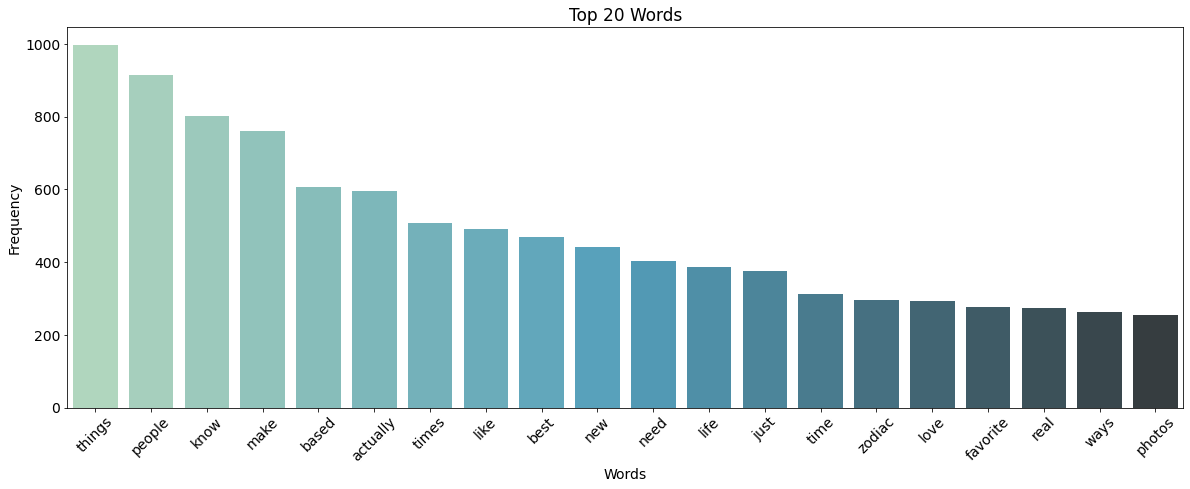

In [12]:
# Plot a bar chart for the top 20 most frequently occuring words
fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x='word',
    y='frequency',
    data=top_20,
    palette='GnBu_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 20 Words', fontsize=17)

plt.show()

## Generate CSVs for d3.js visualisations

In [ ]:
df['word_count'].to_csv('word_count.csv', index = False)
top_20.to_csv('top_20_words.csv', index = False)

## Vectorise text wtih tf-idf

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer;

texts = df['processed_text']
tfidf_vectorizer = TfidfVectorizer(
    min_df=5,
    max_df=0.80,
    max_features=6000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)
tfidf = tfidf_vectorizer.fit_transform(texts)
# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names()


## Run NMF, show topics

In [18]:
from sklearn.decomposition import NMF;

# Run the NMF model
nmf = NMF(
    n_components=40,
    init='nndsvda'    
).fit(tfidf)

# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 6

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df.head(8)

,0,1,2,3,4,5,topics
0,zodiac,sign,zodiac sign,based zodiac,based,character based,zodiac sign based character
1,things,happen,things happen,things people,happened,things happened,things happen people happened
2,make,feel,laugh,make feel,make laugh,want,make feel laugh want
3,know,need know,based,actually know,know lyrics,things know,know need based actually lyrics things
4,people,things people,people try,try,confessions people,people love,people things try confessions love
5,actually,actually know,love actually,people actually,actually make,actually want,actually know love people make want
6,times,tumblr,instagram,internet,times tumblr,twitter,times tumblr instagram internet twitter
7,like,look,look like,looks,looks like,looked,like look looks looked


## Run NMF with gensim to get coherence scores

In [ ]:
!pip install -U gensim

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.80,
    keep_n=6000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 100 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))


In [ ]:
from operator import itemgetter

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

In [ ]:
# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

file_name = 'c_score'

plt.show()

## Join topics to documents

In [ ]:
# Create a df with only the created topics and topic num
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df.head()
# Creating a temp df with the url and topic num to join on
body = df['body'].tolist()

df_temp = pd.DataFrame({
    'body': body,
    'topic_num': docweights.argmax(axis=1)
})

# Merging to get the topic num with url
merged_topic = df_temp.merge(
    topic_df,
    on='topic_num',
    how='left'
)

# Merging with the original df
df_topics = pd.merge(
    df,
    merged_topic,
    on='body',
    how='left'
)

df_topics = df_topics.drop(
    'processed_text',
    axis=1
)
pd.set_option('display.max_colwidth', None)

df_topics[(df_topics["topic_num"] == 15) | 
           (df_topics["topic_num"] == 38) | 
           (df_topics["topic_num"] == 29) | 
           (df_topics["topic_num"] == 4) | 
           (df_topics["topic_num"] == 24) | 
           (df_topics["topic_num"] == 0)  
                    
           ].tail(40)

## Save topic counts to CSV for d3.js visualisations

In [ ]:
df_topic_count = df_topics['topics'].value_counts().to_frame()
df_topic_count = df_topic_count.reset_index()
df_topic_count = df_topic_count.rename(columns={"index": "topic", "topics": "headline_count"})
df_topic_count.to_csv("topic_count.csv", index = False)